In [1]:
import torch
import lib.utils.bookkeeping as bookkeeping
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lib.models.models as models
import lib.models.model_utils as model_utils
from lib.datasets import mnist, maze, protein, synthetic
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils
import os
from lib.datasets.maze import maze_acc
from ruamel.yaml.scalarfloat import ScalarFloat

In [2]:
path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollow8M.pt' 

config_path = os.path.join(path, date, config_name)
checkpoint_path = os.path.join(path, date, model_name)

In [3]:
# creating models
cfg = bookkeeping.load_config(config_path)
cfg.sampler.name = 'LBJF' #ExactSampling' # ElboLBJF CRMTauL CRMLBJF
cfg.sampler.num_corrector_steps = 0
cfg.sampler.corrector_entry_time = ScalarFloat(0.0)
cfg.sampler.num_steps = 500
cfg.sampler.is_ordinal = True
#print(cfg)
device = torch.device(cfg.device)

model = model_utils.create_model(cfg, device)
model = model.float()
print("number of parameters: ", sum([p.numel() for p in model.parameters()]))

#modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
#model.load_state_dict(modified_model_state)
#optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)
optimizer = torch.optim.Adam(model.parameters(), cfg.optimizer.lr)

sampler = sampling_utils.get_sampler(cfg)

state = {"model": model, "optimizer": optimizer, "n_iter": 0}
state = bookkeeping.load_state(state, checkpoint_path)
state['model'].eval()

self.input_embedding torch.float32
number of parameters:  7808643
ema state dict function


In [29]:
samples = np.load('Samples/Maze/mazes_hollow_nonordinalCRMTauL500.npy')
n_samples = samples.shape[0]
samples = samples.reshape(n_samples, -1)
print(samples.shape)
cfg.data.name = 'Maze3SComplete'
cfg.data.batch_size = n_samples

if cfg.data.name == 'Maze3SComplete':
    limit = cfg.data.batch_size
    cfg.data.limit = limit 

dataset = dataset_utils.get_dataset(cfg, device)
dataloader = torch.utils.data.DataLoader(dataset,
    batch_size=cfg.data.batch_size,
    shuffle=cfg.data.shuffle)

for i in dataloader:
    true_dl = i
    c_i = maze_acc(i.cpu().numpy())
    true_dl = true_dl.reshape(cfg.data.batch_size, -1) #.flatten()

(2500, 225)
1000 samples generated.
2000 samples generated.
Accuracy: From 2500 are 100.0% solvable.
Average path length: 38.5016 and prob 17.111822222222223%
Average wall length: 126.0 and prob 56.0%
Average way length: 60.4984 and prob 26.888177777777774%


In [33]:
from scipy.stats import wasserstein_distance
def hellinger_distance(p,q):
    distance = (1.0 / np.sqrt(2) * np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)))
    return distance
#samples = np.load('mazes_hollow_exact.npy')
bins = np.arange(0, 3)
emd_result = []
steps = [750]
for step in steps:
    samples = np.load(f'Samples/Maze/hollow_elbo_CRMTauL{step}_mazes.npy') # f'mazes_hollow_nonordinalCRMTauL{step}.npy')
    emd_list = []
    hell_list = []
    print("step", step)
    samples = samples.reshape(samples.shape[0], -1)
    acc = maze_acc(samples)

    for i in range(samples.shape[0]):
        m_g = samples[i, :]
        m_t = true_dl[i, :].cpu().numpy()
        m_g_prob = np.bincount(m_g) / 3
        m_t_prob = np.bincount(m_t) / 3
        emd_list.append(wasserstein_distance(bins, bins, m_g_prob, m_t_prob))
        hell_list.append(hellinger_distance(m_g_prob, m_t_prob))
    emd_result.append(np.mean(emd_list))
    #print("Step:", step)
    print("# AVG EMD", np.mean(emd_list))
    print("# Hell Distance", np.mean(hell_list))

    m_g_whole = np.bincount(samples.flatten()) / 3
    m_t_whole = np.bincount(true_dl.cpu().numpy().flatten()) / 3
    print("# whole EMD", wasserstein_distance(bins, bins, m_g_whole, m_t_whole))
    print("# whole Hellunger", hellinger_distance(m_g_whole,  m_t_whole))

# Hollow:
# LBJF: 0.0662
# TauL: 0.0656
# Exact: 0.00652

# Hollow ELBO
# LBJF: 64% 0.06874074074074078
# TauL:  63% 0.07068444444444448
# Exact: 63% 0.07009185185185188
    
# Unet:
# LBJF: 50% 0.07241481481481486
# TauL: 40% 0.07448814814814819

# Hollow direct
# LBJF: 0.0719 0.0702814814814815 0.07208296296296297
# TauL: 0.07076  AVG EMD 0.06744888888888892 0.07159703703703707
# rej_rate_maze = [0.6085251628305858, 0.3971528976831892, 0.29737690992794547, 0.23819152995776705, 0.17059221048452358, 0.11267130391333513, 0.06186160933420365, 0.025205536736870884, 0.0069328674408784]
    
# emd_lbjf = np.array([0.07110577777777781, 0.06902400000000003, 0.0672248888888889, 0.06652266666666669, 0.06635022222222224, 0.06605333333333333, 0.06631288888888888, 0.06620622222222224, 0.06611377777777777,0.06583822222222223])
# emd_taul = np.array([0.11720355555555556, 0.07994488888888888, 0.06799377777777779, 0.06616800000000002, 0.06516800000000002, 0.06496000000000002, 0.064504888888888893, 0.064016, 0.06332266666666667, 0.063296])
# emd_lbjf = np.array([])
    
#acc_taul_nonord = np.array(0,0,0.008, 0.01, 0.1, 0.36, 0.65, 78, 83, 85)


step 750
Accuracy: From 375 are 62.4% solvable.
Average path length: 32.01709401709402 and prob 14.229819563152898%
Average wall length: 126.25213675213675 and prob 56.11206077872745%
Average way length: 66.73076923076923 and prob 29.658119658119656%
# AVG EMD 0.0689777777777778
# Hell Distance 0.6434839707007393
# whole EMD 0.0048959999999999
# whole Hellunger 187.60573494004615


In [ ]:
print(emd_result)

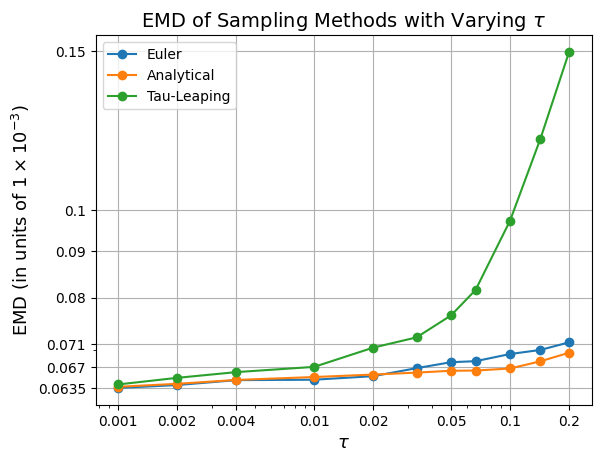

In [2]:
import numpy as np
import matplotlib.pyplot as plt
steps_plot = np.round(1 / np.array([5, 10,  20, 50, 100, 250, 500, 1000]), 3)
steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 1000])
# taul ordinal [0.11571022222222223, 0.07852266666666667, 0.06904, 0.0641937777777778, 0.06518755555555557, 0.06270933333333335, 0.06255288888888891, 0.06282488888888889, 0.06536, 0.0651004444
# [0.07136533333333336, 0.06927288888888891, 0.06681955555555558, 0.06701688888888892, 0.06446933333333334, 0.06353244444444445, 0.06487644444444444, 0.06480533333333333, 0.06684444444444444, 0.06546666666666667
emd_anal = np.array([0.06950222222222226, 0.068,0.0667608888888889, 0.06641244444444447, 0.06637511111111113, 0.066064, 0.06573333333333332, 0.06532133333333335, 0.06483911111111112, 0.0642,  0.06371733333333333])
emd_lbjf = np.array([0.07136533333333336, 0.07,0.06927288888888891, 0.06801688888888892, 0.06784444444444444, 0.06681955555555558, 0.06546666666666667,0.06487644444444444, 0.06480533333333333, 0.0640, 0.06353244444444445])
#emd_taul = np.array([0.11720355555555556, 0.07994488888888888, 0.06799377777777779, 0.06616800000000002, 0.06516800000000002, 0.06496000000000002, 0.064504888888888893, 0.064016, 0.06332266666666667, 0.063296])

emd_taul_no = np.array([0.1499057777777778, 0.12, 0.09572977777777783, 0.0811555555555556, 0.07247822222222228, 0.06952888888888893, 0.06894755555555562, 0.06640533333333336, 0.06489244444444446, 0.0641368888888889, 0.06372977777777777])
# correct: emd_taul_no
emd_taul_no_correct = [0.14973511111111115,  0.12, 0.09737244444444448, 0.08158222222222225, 0.0764568888888889, 0.07227911111111111, 0.0704071111111111, 0.06703822222222221, 0.06614533333333331, 0.06518844444444442, 0.06409866666666665]
#plt.gca().invert_xaxis()
plt.plot(steps, emd_lbjf, label='Euler', marker='o') # 'o' für Kreise
plt.plot(steps, emd_anal, label='Analytical', marker='o')
plt.plot(steps, emd_taul_no_correct, label='Tau-Leaping', marker='o')
plt.xlabel('$\\tau$', fontsize=13)
plt.ylabel('EMD (in units of $1\\times 10^{-3}$)', fontsize=13) 
plt.title('EMD of Sampling Methods with Varying $\\tau$', fontsize=14)
plt.legend()
plt.yscale('log')
plt.xscale('log')
steps_y = [0.15, 0.1, 0.09, 0.08, 0.071, 0.0670,0.0635]
plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
plt.grid(True)
plt.savefig('emd_plot_tau.pdf')
plt.show()

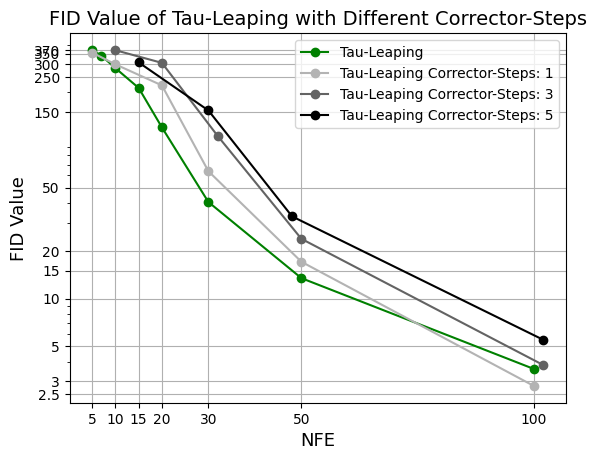

In [10]:
pc_1_steps =[5, 10, 20, 30, 50, 100]
nfe_01_1_fid = [355.30401756086303, 299.8788404145761, 220.94562240586495, 63.526149427266375, 17.06536557569376, 2.813092226544086]
pc_3_steps = [10, 20, 32, 50, 102]
nfe_01_3_fid = [368.2020780292752, 306.44852994200113, 105.99785122999572, 23.8096318610784, 3.8135712497214342]
pc_5_steps =[15, 30, 48, 102]
nfe_01_5_fid = [308.4621460802384, 153.52888664861723, 32.976239962089096, 5.501552200792844]

steps = np.array([5, 7, 10, 15, 20, 30, 50, 100]) # , 250, 500, 750, 1000, 1500])
fid_taul = np.array([369.82769160402194, 339.7123739152373, 283.87526811768316, 212.90508021598973, 120.04226304249106, 40.6234648618652, 13.453524786963495, 3.6])#, 2.98404509903506, 2.5895556730263706, 2.51, 2.48, 2.460157370950734])


colors = ['black', 'gray', 'lightgray']
colors = ['black', 'gray', (0.7, 0.7, 0.7)]  
colors = ['black', (0.39, 0.39, 0.39), (0.7, 0.7, 0.7)]  # Graustufen-Farben
plt.plot(steps, fid_taul, marker='o', color='green', label='Tau-Leaping')
plt.plot(pc_1_steps, nfe_01_1_fid, marker='o', label='Tau-Leaping Corrector-Steps: 1', color=colors[2])
plt.plot(pc_3_steps, nfe_01_3_fid, marker='o', label='Tau-Leaping Corrector-Steps: 3', color=colors[1])
plt.plot(pc_5_steps, nfe_01_5_fid, marker='o', label='Tau-Leaping Corrector-Steps: 5', color=colors[0])

plt.xlabel('NFE', fontsize=13)
plt.ylabel('FID Value', fontsize=13)
plt.title('FID Value of Tau-Leaping with Different Corrector-Steps', fontsize=14)
plt.legend()
plt.grid(True)

plt.yscale('log')
steps_y = [370, 350, 300, 250, 150, 50, 20, 15, 10, 5, 3, 2.5]
steps_plot = [5, 10, 15, 20, 30, 50, 100]
plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
#plt.savefig('fid_tau_corrector.pdf')
plt.show()

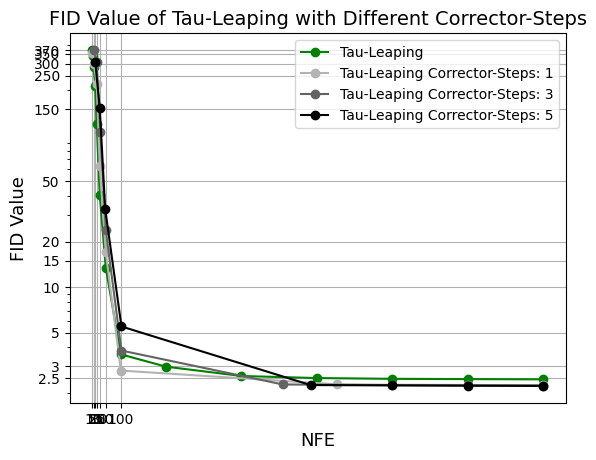

In [5]:
import numpy as np
import matplotlib.pyplot as plt
n = 5
pc_1_steps =[5, 10, 20, 30, 50, 100, 818, 1000, 1250, 1500]
nfe_01_1_fid = [355.30401756086303, 299.8788404145761, 220.94562240586495, 63.526149427266375, 17.06536557569376, 2.813092226544086, 2.278975460098858, 2.2671159746989906, 2.259, 2.252]
pc_3_steps = [10, 20, 32, 50, 102, 637, 1000, 1250, 1500]
nfe_01_3_fid = [368.2020780292752, 306.44852994200113, 105.99785122999572, 23.8096318610784, 3.8135712497214342, 2.276187915395326, 2.2539787186312788, 2.2466063307386435, 2.238]
pc_5_steps =[15, 30, 48, 102, 729, 1000, 1250, 1500]
nfe_01_5_fid = [308.4621460802384, 153.52888664861723, 32.976239962089096, 5.501552200792844, 2.2559381898192896, 2.2450412804101074, 2.234, 2.2267139529323856]

steps = np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 750, 1000, 1250, 1500]) # , 250, 500, 750, 1000, 1500])
fid_taul = np.array([369.82769160402194, 339.7123739152373, 283.87526811768316, 212.90508021598973, 120.04226304249106, 40.6234648618652, 13.453524786963495, 3.6, 2.98404509903506, 2.5895556730263706, 2.51, 2.48, 2.47, 2.460157370950734])



colors = ['black', 'gray', 'lightgray']
colors = ['black', 'gray', (0.7, 0.7, 0.7)]  
colors = ['black', (0.39, 0.39, 0.39), (0.7, 0.7, 0.7)]  # Graustufen-Farben
plt.plot(steps, fid_taul, marker='o', color='green', label='Tau-Leaping')
plt.plot(pc_1_steps, nfe_01_1_fid, marker='o', label='Tau-Leaping Corrector-Steps: 1', color=colors[2])
plt.plot(pc_3_steps, nfe_01_3_fid, marker='o', label='Tau-Leaping Corrector-Steps: 3', color=colors[1])
plt.plot(pc_5_steps, nfe_01_5_fid, marker='o', label='Tau-Leaping Corrector-Steps: 5', color=colors[0])

plt.xlabel('NFE', fontsize=13)
plt.ylabel('FID Value', fontsize=13)
plt.title('FID Value of Tau-Leaping with Different Corrector-Steps', fontsize=14)
plt.legend()
plt.grid(True)

plt.yscale('log')
steps_y = [370, 350, 300, 250, 150, 50, 20, 15, 10, 5, 3, 2.5]
steps_plot = [5, 10, 15, 20, 30, 50, 100, 250, 500, 1000, 1250, 1500]
plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
#plt.savefig('fid_tau_corrector.pdf')
plt.show()

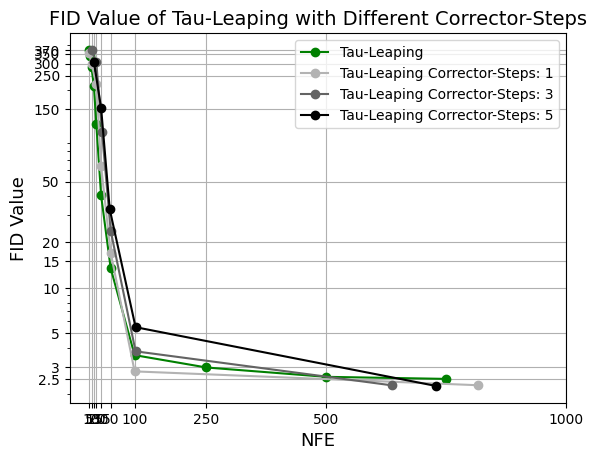

In [11]:
import numpy as np
import matplotlib.pyplot as plt
n = 5
"""
pc_1_steps =[5, 10, 20, 30, 50, 100, 818]#, 1000, 1250, 1500]
nfe_01_1_fid = [355.30401756086303, 299.8788404145761, 220.94562240586495, 63.526149427266375, 17.06536557569376, 2.813092226544086, 2.27897546009885]#8, 2.2671159746989906, 2.259, 2.252]
pc_3_steps = [10, 20, 32, 50, 102, 637]#7, 1000, 1250, 1500]
nfe_01_3_fid = [368.2020780292752, 306.44852994200113, 105.99785122999572, 23.8096318610784, 3.8135712497214342, 2.276187915395326]#, 2.2539787186312788, 2.2466063307386435, 2.238]
pc_5_steps =[15, 30, 48, 102, 729]#, 1000, 1250, 1500]
nfe_01_5_fid = [308.4621460802384, 153.52888664861723, 32.976239962089096, 5.501552200792844, 2.2559381898192896]#, 2.2450412804101074, 2.234, 2.2267139529323856]
"""
pc_1_steps =[5, 10, 20, 30, 50, 100, 818]#, 1000, 1250, 1500]
nfe_01_1_fid = [355.30401756086303, 299.8788404145761, 220.94562240586495, 63.526149427266375, 17.06536557569376, 2.813092226544086, 2.27897546009885]#8, 2.2671159746989906, 2.259, 2.252]
pc_3_steps = [10, 20, 32, 50, 102, 637]#7, 1000, 1250, 1500]
nfe_01_3_fid = [368.2020780292752, 306.44852994200113, 105.99785122999572, 23.8096318610784, 3.8135712497214342, 2.276187915395326]#, 2.2539787186312788, 2.2466063307386435, 2.238]
pc_5_steps =[15, 30, 48, 102, 729]#, 1000, 1250, 1500]
nfe_01_5_fid = [308.4621460802384, 153.52888664861723, 32.976239962089096, 5.501552200792844, 2.2559381898192896]#, 2.2450412804101074, 2.234, 2.2267139529323856]


steps = np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 750])#, 1000], 1250, 1500]) # , 250, 500, 750, 1000, 1500])
fid_taul = np.array([369.82769160402194, 339.7123739152373, 283.87526811768316, 212.90508021598973, 120.04226304249106, 40.6234648618652, 13.453524786963495, 3.6, 2.98404509903506, 2.5895556730263706, 2.51])#, 2.47, 2.460157370950734])



colors = ['black', 'gray', 'lightgray']
colors = ['black', 'gray', (0.7, 0.7, 0.7)]  
colors = ['black', (0.39, 0.39, 0.39), (0.7, 0.7, 0.7)]  # Graustufen-Farben
plt.plot(steps, fid_taul, marker='o', color='green', label='Tau-Leaping')
plt.plot(pc_1_steps, nfe_01_1_fid, marker='o', label='Tau-Leaping Corrector-Steps: 1', color=colors[2])
plt.plot(pc_3_steps, nfe_01_3_fid, marker='o', label='Tau-Leaping Corrector-Steps: 3', color=colors[1])
plt.plot(pc_5_steps, nfe_01_5_fid, marker='o', label='Tau-Leaping Corrector-Steps: 5', color=colors[0])

plt.xlabel('NFE', fontsize=13)
plt.ylabel('FID Value', fontsize=13)
plt.title('FID Value of Tau-Leaping with Different Corrector-Steps', fontsize=14)
plt.legend()
plt.grid(True)

plt.yscale('log')
steps_y = [370, 350, 300, 250, 150, 50, 20, 15, 10, 5, 3, 2.5]
steps_plot = [5, 10, 15, 20, 30, 50, 100, 250, 500, 1000]#, 1250, 1500]
plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
#plt.savefig('fid_tau_corrector.pdf')
plt.show()

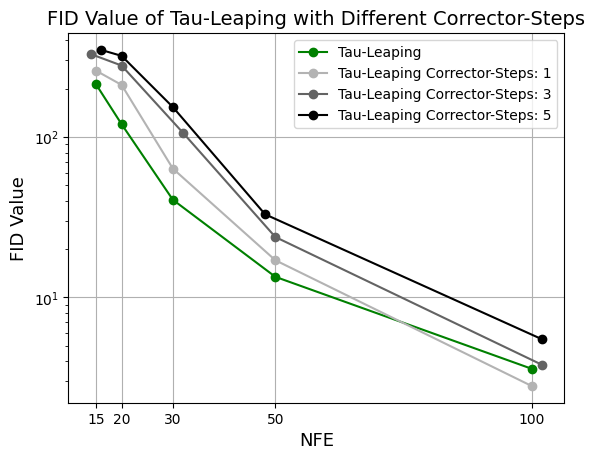

In [128]:
# 5: 10, 16, 22, 25, 30, 48, 75, 102
# 3: 10, 14, 20, 32, 50, 75, 102
# 1: 10, 15, 20, 30, 50, 

"""
pc_1_steps =[5, 10, 20, 30, 50, 100, 818]#, 1000, 1250, 1500]
nfe_01_1_fid = [355.30401756086303, 299.8788404145761, 220.94562240586495, 63.526149427266375, 17.06536557569376, 2.813092226544086, 2.27897546009885]#8, 2.2671159746989906, 2.259, 2.252]
pc_3_steps = [10, 20, 32, 50, 102, 637]#7, 1000, 1250, 1500]
nfe_01_3_fid = [368.2020780292752, 306.44852994200113, 105.99785122999572, 23.8096318610784, 3.8135712497214342, 2.276187915395326]#, 2.2539787186312788, 2.2466063307386435, 2.238]
pc_5_steps =[15, 30, 48, 102, 729]#, 1000, 1250, 1500]
nfe_01_5_fid = [308.4621460802384, 153.52888664861723, 32.976239962089096, 5.501552200792844, 2.2559381898192896]#, 2.2450412804101074, 2.234, 2.2267139529323856]
"""
# 1: 250, 500: [2.252598541276768, 2.3627632134412977]
# 3: [2.3423048205916643, [3.9064362368672505]
pc_1_steps =[15, 20, 30, 50, 75, 100]
nfe_01_1_fid = [258.788404145761, 210.94562240586495, 63.526149427266375, 17.06536557569376, 2.813092226544086]
pc_3_steps = [14, 20, 32, 50, 75, 102]
nfe_01_3_fid = [328.2020780292752, 278.44852994200113, 105.99785122999572, 23.8096318610784, 3.8135712497214342]
pc_5_steps =[16, 20, 30, 48, 75, 102]
nfe_01_5_fid = [348.4621460802384, 320, 153.52888664861723, 32.976239962089096, 5.501552200792844]

steps = np.array([15, 20, 30, 50, 100]) # , 250, 500, 750, 1000, 1500])
fid_taul = np.array([212.90508021598973, 120.04226304249106, 40.6234648618652, 13.453524786963495, 3.6])#, 2.98404509903506, 2.5895556730263706, 2.51, 2.48, 2.460157370950734])


colors = ['black', 'gray', 'lightgray']
colors = ['black', 'gray', (0.7, 0.7, 0.7)]  
colors = ['black', (0.39, 0.39, 0.39), (0.7, 0.7, 0.7)]  # Graustufen-Farben
plt.plot(steps, fid_taul, marker='o', color='green', label='Tau-Leaping')
plt.plot(pc_1_steps, nfe_01_1_fid, marker='o', label='Tau-Leaping Corrector-Steps: 1', color=colors[2])
plt.plot(pc_3_steps, nfe_01_3_fid, marker='o', label='Tau-Leaping Corrector-Steps: 3', color=colors[1])
plt.plot(pc_5_steps, nfe_01_5_fid, marker='o', label='Tau-Leaping Corrector-Steps: 5', color=colors[0])

plt.xlabel('NFE', fontsize=13)
plt.ylabel('FID Value', fontsize=13)
plt.title('FID Value of Tau-Leaping with Different Corrector-Steps', fontsize=14)
plt.legend()
plt.grid(True)

plt.yscale('log')
steps_y = [350, 300, 250, 150, 50, 20, 15, 10, 5, 3, 2.5]
steps_plot = [15, 20, 30, 50, 75, 100]
#plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
#plt.savefig('fid_tau_corrector.pdf')
plt.show()

In [2]:
for i in range(0):
    print(i)

In [150]:
max_t = 0.99999
min_t = 0.01
num_steps = [515]
nfe_10_01 = []
for steps in num_steps:
    ts = np.concatenate(
        (np.
        linspace(max_t, min_t, steps), np.array([0]))
    )

    k = 0 
    for i, t in (enumerate(ts[0:-1])):
        #print(i+1)
        if t <= 0.1:
            for j in range(5):
                k += 1
                #print(k)

    nfe_10_01.append(i+1+k)
print(nfe_10_01)
# 5: 10, 16, 22, 25, 30, 48, 75, 102
# 3: 10, 14, 20, 32, 50, 75, 102
# 1: 10, 15, 20, 30, 50, 

[750]
